In [1]:
from defillama2 import DefiLlama
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("fivethirtyeight")

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
def human_format_dollar_or_num(dollar=False, decimals=0):
    """ 
    Return a function for formatting matplot axis numbers human friendly. 

    Parameters
    ----------
    dollar: logical
        If True, will add $ in front of the numbers.
    decimals: int
        Number of decimals to display.
    """

    base_fmt = '%.{}f%s'.format(decimals)
    if dollar:
        base_fmt = '$' + base_fmt

    def human_format(num, pos): # pos is necessary as it'll be used by matplotlib
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return base_fmt % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])
    return human_format

## Create a DefiLlama instance

In [3]:
obj = DefiLlama()

## Get latest yields for all pools, along with other info

In [4]:
df = obj.get_pools_yields() # See https://defillama.com/yields for the meaning of columns.
print(df.shape)
df.head() 

(9484, 29)


,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,...,apyBase7d,apyMean30d,volumeUsd1d,volumeUsd7d,predictedClass,predictedProbability,binnedConfidence
0,Ethereum,lido,STETH,5712657200,4.6000,NaN,4.6000,...,NaN,4.6840,NaN,NaN,Down,52.0000,1.0000
1,Ethereum,makerdao,USDC,2269422192,NaN,NaN,0.0000,...,NaN,0.0000,NaN,NaN,None,NaN,NaN
2,Tron,justlend,BTC,1852906552,0.0000,0.0394,0.0394,...,NaN,0.0387,NaN,NaN,Down,50.0000,1.0000
3,Ethereum,aave-v2,STETH,1125880515,0.0000,NaN,0.0000,...,NaN,0.0000,NaN,NaN,None,NaN,NaN
4,Ethereum,makerdao,WETH,831434676,NaN,NaN,0.0000,...,NaN,0.0000,NaN,NaN,None,NaN,NaN


In [5]:
df.columns

Index(['chain', 'project', 'symbol', 'tvlUsd', 'apyBase', 'apyReward', 'apy',
       'rewardTokens', 'pool', 'apyPct1D', 'apyPct7D', 'apyPct30D',
       'stablecoin', 'ilRisk', 'exposure', 'poolMeta', 'mu', 'sigma', 'count',
       'outlier', 'underlyingTokens', 'il7d', 'apyBase7d', 'apyMean30d',
       'volumeUsd1d', 'volumeUsd7d', 'predictedClass', 'predictedProbability',
       'binnedConfidence'],
      dtype='object')

In [6]:
# let's look at TriCrypto pools on Ethereum and Arbitrum, discarding outlier pools (with extreme APYs and usually low TVL)
is_true = (df.symbol.isin(['yvCurve-Tricrypto', 'USDT-WBTC-WETH', 'WBTC-WETH-USDC']) & 
           df.chain.isin(['Ethereum', 'Arbitrum']) & 
           (~df.outlier))

# I guess columns `mu` and `sigma` are mean and standard deviation of past APYs over `count` many APYs.
# `apyPct7D` is pct change in APY for the last 7 days; `apyPct30D` is NaN for all records.
# `predictedClass` is DeFiLlama's prediction on which way the APY is heading to. 
cols = ['chain', 'project', 'symbol', 'tvlUsd', 'apyBase', 'apyReward', 'apy', 'apyPct7D', 
        'mu', 'sigma', 'count', 'predictedClass', 'predictedProbability']
df.loc[is_true, cols].sort_values('apy', ascending=False)

,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
45,Ethereum,convex-finance,USDT-WBTC-WETH,145621176,0.5538,8.2734,8.8271,-0.4083,13.4146,0.3750,266,Stable/Up,69.0000
895,Arbitrum,balancer,WBTC-WETH-USDC,2906177,1.6708,5.5100,7.1808,-5.9794,14.4536,0.3062,322,Stable/Up,80.0000
647,Ethereum,concentrator,USDT-WBTC-WETH,4767821,NaN,NaN,6.1200,-3.3100,16.9993,0.5379,220,Stable/Up,58.0000
43,Ethereum,curve,USDT-WBTC-WETH,152883133,0.5538,4.6895,5.2433,0.1893,8.1903,0.1830,323,Stable/Up,93.0000
4735,Arbitrum,pickle,USDT-WBTC-WETH,123125,NaN,NaN,2.1682,-0.3461,8.9777,0.1893,235,Stable/Up,85.0000
250,Arbitrum,curve,USDT-WBTC-WETH,18401583,0.5541,0.0411,0.5952,0.0998,1.5908,0.0828,279,Stable/Up,84.0000
3076,Ethereum,curve,USDT-WBTC-WETH,315821,0.2227,0.0000,0.2227,0.2154,0.6500,0.0448,279,Stable/Up,70.0000
7310,Ethereum,convex-finance,USDT-WBTC-WETH,30528,0.2227,0.0000,0.2227,0.2154,0.8560,0.0635,155,Down,65.0000


In [7]:
# let's find multi-sided stablecoin pools without IL and with TVL > $1M on Arbitrum
is_true = (df.chain == 'Arbitrum') & df.stablecoin & (df.ilRisk == 'no') & (df.exposure == 'multi') & (df.tvlUsd > 1e6) & (~df.outlier)
df.loc[is_true, cols].sort_values('apy', ascending=False)

,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
1232,Arbitrum,swapfish,USX-USDC,1700113,NaN,9.8536,9.8536,-9.9262,19.7806,0.3638,20,Stable/Up,83.0000
576,Arbitrum,frax,VST-FRAX,5640234,NaN,8.6104,8.6104,-2.3197,7.1152,0.0868,11,Down,57.0000
930,Arbitrum,swapfish,MIM-USDC,2759430,NaN,7.1747,7.1747,-9.4377,14.8823,0.2610,20,Stable/Up,74.0000
553,Arbitrum,beefy,MIM-USDC-USDT,5985428,NaN,NaN,6.5339,-0.1382,11.2344,0.2035,323,Stable/Up,75.0000
642,Arbitrum,swapfish,DAI-USDC,4828994,NaN,5.6767,5.6767,-4.1101,8.4919,0.1313,20,Stable/Up,75.0000
755,Arbitrum,swapfish,FRAX-USDC,3810809,NaN,5.1952,5.1952,-8.4122,12.5311,0.2360,20,Stable/Up,87.0000
559,Arbitrum,swapfish,USDT-USDC,5878038,NaN,4.6636,4.6636,-3.5672,7.3381,0.1110,20,Stable/Up,71.0000
880,Arbitrum,beefy,USDT-USDC,3007246,NaN,NaN,2.6823,0.2963,5.1058,0.1770,323,Stable/Up,87.0000
1470,Arbitrum,beefy,FRAX-USDC,1221294,NaN,NaN,2.4599,-7.3367,12.0357,0.2946,21,Stable/Up,82.0000
579,Arbitrum,curve,VST-FRAX,5633373,2.1589,0.0000,2.1589,1.4526,0.3339,0.0224,164,Down,70.0000


## Get historical APY and TVL of a pool

In [8]:
# get pool ids
dat = obj.get_pools_yields()
pool_ids = dat.pool
pool_ids

0       747c1d2a-c668-4682-b9f9-296708a3dd90
1       051c1a54-df05-4bc4-9d73-c17508acae23
2       71418c17-d2aa-4eff-b68a-806fff9ec951
3       0e458a5b-fd99-4667-8706-dd938934cb0c
4       51d2f8d4-1fb5-4f6b-938b-e9cd17ca1ceb
                        ...                 
9479    dceb0bd3-a4a6-4a4f-bac0-9277452b5829
9480    2a88d829-0ebb-491b-b70a-29622fd2f3ed
9481    8e91c2b5-1a00-4579-ac06-7036fe83cefa
9482    7f9548a6-28ef-4c24-aceb-8a4be4dbdd2e
9483    76d6631e-d2f6-4869-8bfe-2d49f27da76f
Name: pool, Length: 9484, dtype: object

In [9]:
pool_id = pool_ids[10]
meta = dat.loc[dat.pool == pool_id, ['chain', 'project', 'symbol']]
meta

,chain,project,symbol
10,Ethereum,curve,FRAX-3CRV


In [10]:
df = obj.get_pool_hist_apy(pool_id)
df.head()

,tvlUsd,apy,apyBase,apyReward,il7d,apyBase7d
date,,,,,,
2022-02-11 00:00:00+00:00,"3,084,521,689.0000",4.7600,NaN,NaN,NaN,NaN
2022-02-12 00:00:00+00:00,"3,078,678,236.0000",4.7600,NaN,NaN,NaN,NaN
2022-02-13 00:00:00+00:00,"3,081,144,410.0000",4.7200,NaN,NaN,NaN,NaN
2022-02-14 00:00:00+00:00,"3,084,811,426.0000",4.6300,NaN,NaN,NaN,NaN
2022-02-15 00:00:00+00:00,"3,088,497,889.0000",5.0500,NaN,NaN,NaN,NaN


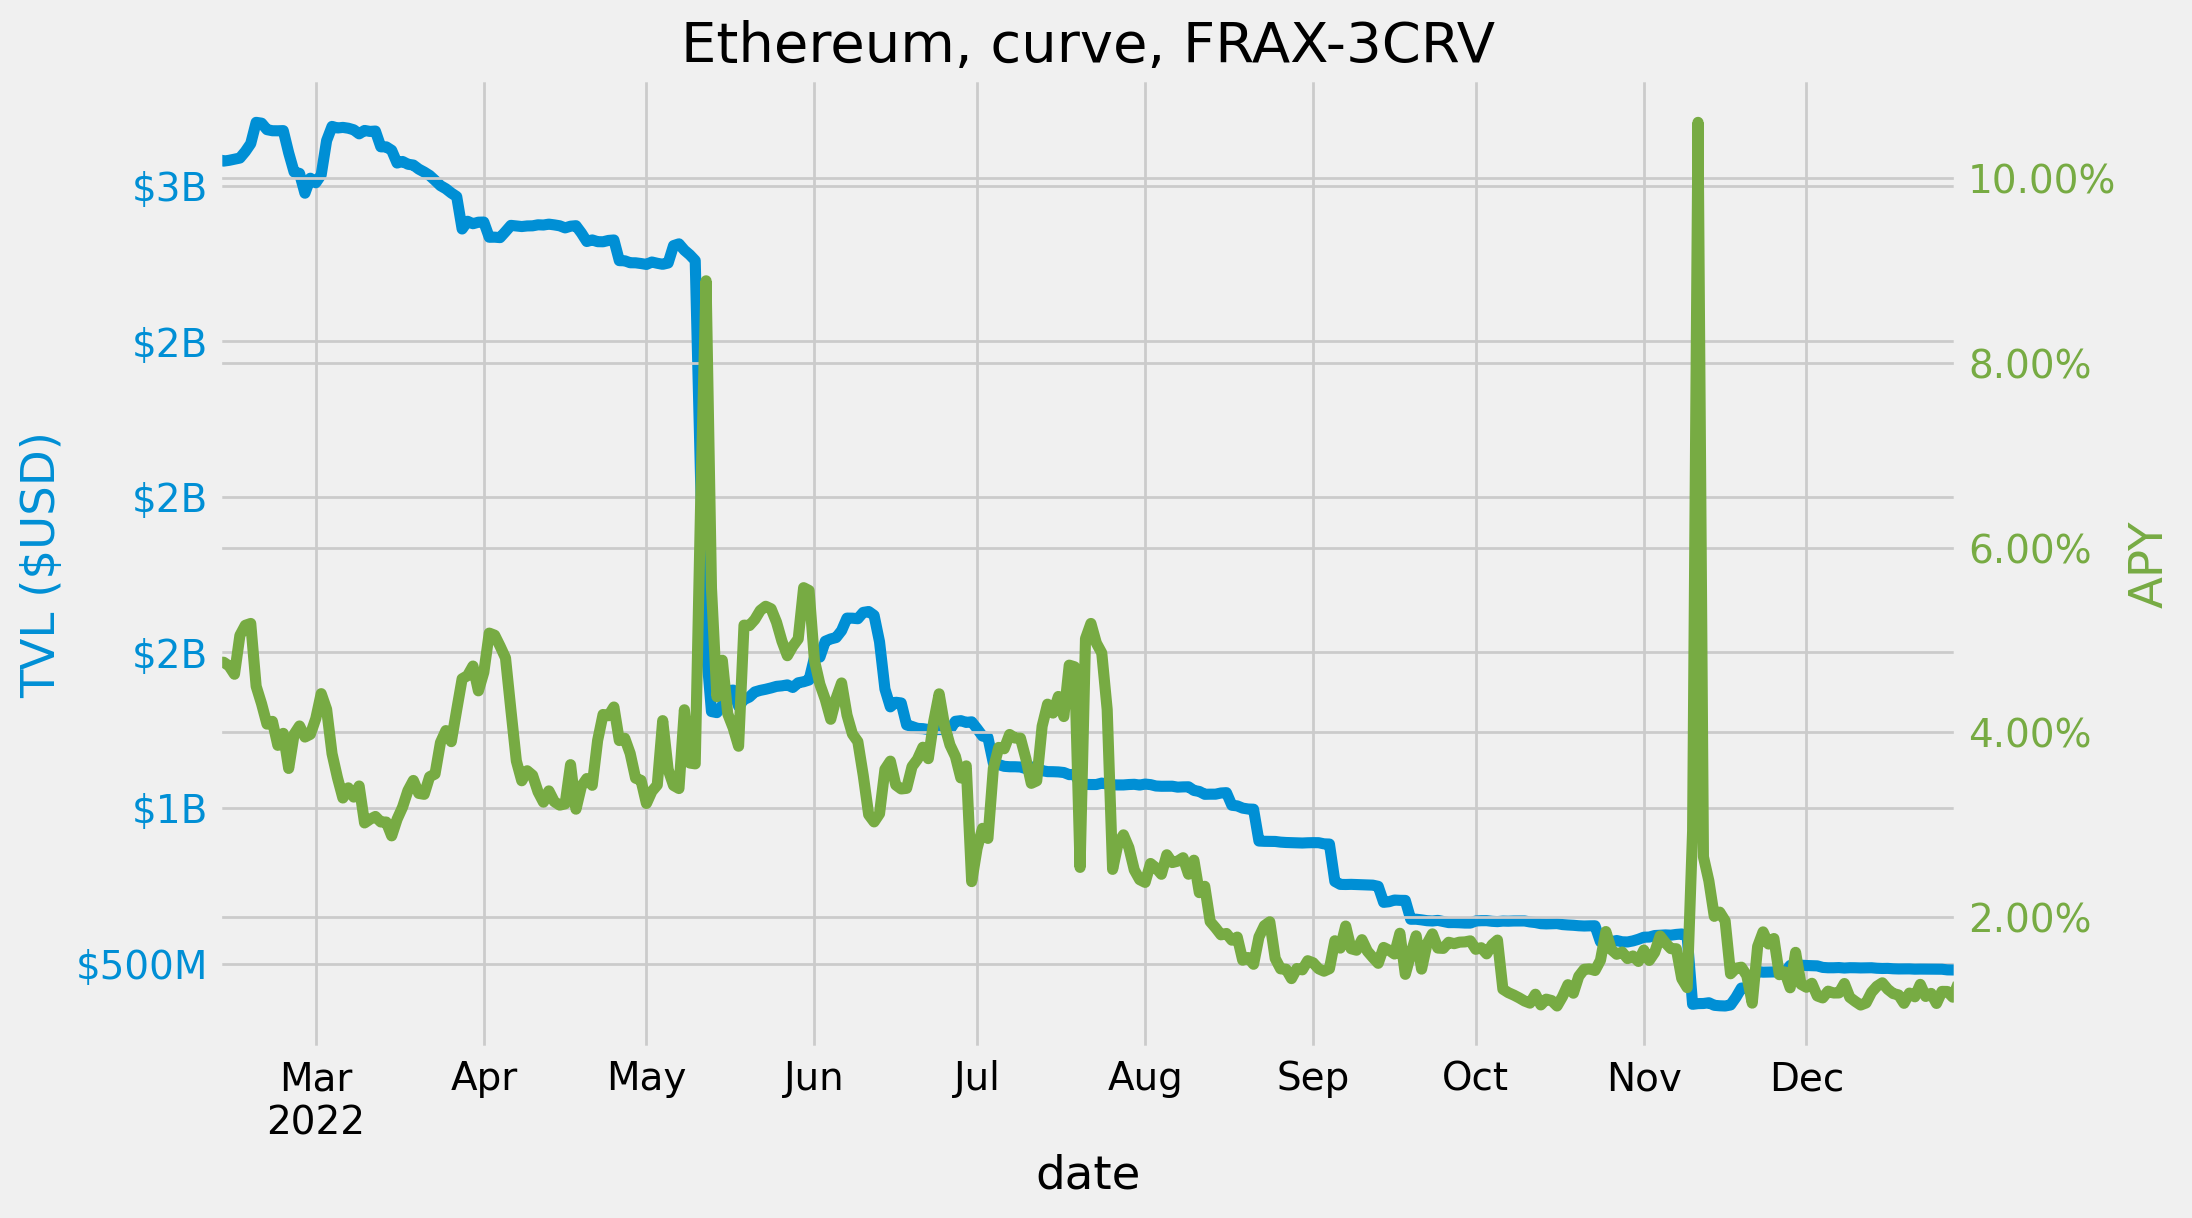

In [11]:
# plot both TVL and APY over time to see their relationships. 
ax1 = df.tvlUsd.plot()
dollar_formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax1.yaxis.set_major_formatter(dollar_formatter)
for tl in ax1.get_yticklabels():
    tl.set_color('#008FD5')
ax1.set_ylabel('TVL ($USD)', color='#008FD5')

ax2 = ax1.twinx()
ax2.plot(df.index, df.apy, color='#77AB43')
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=2))
for tl in ax2.get_yticklabels():
    tl.set_color('#77AB43')
ax2.set_ylabel('APY', color='#77AB43')

fig_tit = ', '.join(meta.values.tolist()[0])
plt.title(fig_tit);    